In [1]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib as mpl

import seaborn as sns
sns.set_palette("muted")
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
def truncate_normal(input: torch.Tensor, radius):
    in_norm = input.norm(dim=1, keepdim=True)
    in_norm[in_norm > radius] = radius
    return input * in_norm / input.norm(dim=1, keepdim=True)

In [3]:
from torch import nn


class PolynomialLoss(nn.Module):
    """
    Poly-tailed margin based losses that decay as v^{-\alpha} for \alpha > 0.
    The theory here is that poly-tailed losses do not have max-margin behavior
    and thus can work with importance weighting.
    Poly-tailed losses are not defined at v=0 for v^{-\alpha}, and so there are
    several variants that are supported via the [[type]] option
    exp : f(v):= exp(-v+1) for v < 1, 1/v^\alpha otherwise
    logit: f(v):= 1/log(2)log(1+exp(-v+1)) for v < 1, 1/v^\alpha else.
    """

    allowed_types = {"logit"}

    def __init__(self, type: str, alpha: float, reduction: str = "none"):
        super().__init__()
        self.type = type
        assert type in self.allowed_types
        self.alpha = float(alpha)
        assert reduction == "none"

    def margin_fn(self, margin_vals: torch.Tensor):
        indicator = margin_vals <= 1
        inv_part = torch.pow(
            margin_vals.abs(), -1 * self.alpha
        )  # prevent exponentiating negative numbers by fractional powers
        if self.type == "logit":
            indicator = margin_vals <= 1
            inv_part = torch.pow(margin_vals.abs(),-1*self.alpha)
            logit_inner = -1 * margin_vals
            logit_part = torch.nn.functional.softplus(logit_inner)/(math.log(1+math.exp(-1)))
            scores = logit_part * indicator + inv_part * (~indicator)
            return scores

    def forward(self, logits, target):
        target_sign = 2 * target - 1
        margin_scores = (logits[:, 1] - logits[:, 0]) * target_sign
        loss_values = self.margin_fn(margin_scores)
        return loss_values

In [4]:
from itertools import product

run = 0

for weight_type, loss_type in product(["No IW", "IW"], ["ce", "poly"]):

    torch.random.manual_seed(1)

    class_one_num = 20
    class_two_num = 200
    alpha = 1.0
    num_epochs = int(1e6)
    batch_size = class_one_num + class_two_num
    lr = 1.0
    device = "cuda"

    class_one = truncate_normal(torch.randn(class_one_num, 2), 5) + torch.tensor([[0, 5]])
    class_two = truncate_normal(torch.randn(class_two_num, 2), 5) + torch.tensor([[5, 0]])

    x_seq = torch.cat((class_one, class_two), dim=0)
    y_seq = torch.cat(
        (torch.zeros(class_one.shape[0], dtype=torch.long), torch.ones(class_two.shape[0], dtype=torch.long))
    )

    dataset = torch.utils.data.TensorDataset(x_seq, y_seq)
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=True
    )

    model = torch.nn.Linear(2, 2)
    
    model = model.to(device)

    if loss_type == "ce":
        loss_fn = torch.nn.CrossEntropyLoss(reduction="none")
    else:
        loss_fn = PolynomialLoss(type="logit", alpha=alpha)

    optimizer = optim.SGD(model.parameters(), lr=lr)

    for i in range(num_epochs):
        for xs, ys in dataloader:
            xs = xs.to(device)
            ys = ys.to(device)

            optimizer.zero_grad()

            logits = model(xs)

            if weight_type == "IW":
                loss_ratio = (ys == 1) + (ys == 0) * class_two_num / float(class_one_num)
            else:
                loss_ratio = torch.ones(ys.shape[0])
            loss_ratio = loss_ratio.to(device)
            
            loss = torch.mean(loss_fn(logits, ys) * loss_ratio)

            loss.backward()

            optimizer.step()
        if i % 100000 == 0:
            print(f"Epoch {i}: loss={loss.item()}")

    model = model.cpu()
    torch.save(model.state_dict(), f"./weights/model_{weight_type}_{loss_type}_{lr}_{num_epochs}.ckpt")

Epoch 0: loss=0.1309681087732315
Epoch 100000: loss=5.013841018808307e-06
Epoch 200000: loss=2.527365950300009e-06
Epoch 300000: loss=1.69800500771089e-06
Epoch 400000: loss=1.2846443269154406e-06
Epoch 500000: loss=1.0289242027283763e-06
Epoch 600000: loss=8.647608069622947e-07
Epoch 700000: loss=7.433959012814739e-07
Epoch 800000: loss=6.447866098824306e-07
Epoch 900000: loss=5.71641692204139e-07
Epoch 0: loss=0.5528664588928223
Epoch 100000: loss=0.004913980141282082
Epoch 200000: loss=0.0039004480931907892
Epoch 300000: loss=0.003406997537240386
Epoch 400000: loss=0.0030970729421824217
Epoch 500000: loss=0.0028747704345732927
Epoch 600000: loss=0.002706297906115651
Epoch 700000: loss=0.00256919814273715
Epoch 800000: loss=0.0024607640225440264
Epoch 900000: loss=0.00236327201128006
Epoch 0: loss=0.6820685863494873
Epoch 100000: loss=5.020955541112926e-06
Epoch 200000: loss=2.5306355837528827e-06
Epoch 300000: loss=1.69801398897107e-06
Epoch 400000: loss=1.2868174508184893e-06
Epoch

findfont: Font family ['times'] not found. Falling back to DejaVu Sans.


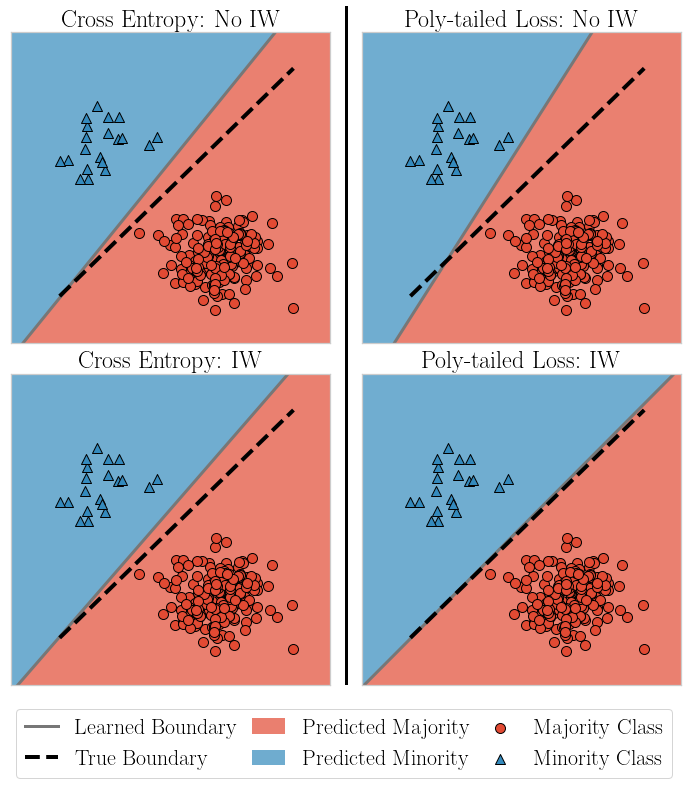

In [6]:
from itertools import product
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

plt.rc('text', usetex=True)
plt.rc('font', family='times')
palette = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
sns.set_palette(palette)


fig, axes = plt.subplots(figsize=(12, 12), nrows=2, ncols=2)

def ymap(xseq, weight, bias):
    print(weight)
    print(bias)
    return (xseq * weight[0] + bias) / (-1 * weight[1])

lr = 1.0
num_epochs = int(1e5)

for i, (weight_type, loss_type) in enumerate(product(["No IW", "IW"], ["ce", "poly"])):
    torch.random.manual_seed(1)

    class_one_num = 20
    class_two_num = 200
    alpha = 1.0
    num_epochs = int(1e6)
    batch_size = class_one_num + class_two_num
    lr = 0.1
    device = "cuda"

    class_one = truncate_normal(torch.randn(class_one_num, 2), 5) + torch.tensor([[0, 5]])
    class_two = truncate_normal(torch.randn(class_two_num, 2), 5) + torch.tensor([[5, 0]])

    x_seq = torch.cat((class_one, class_two), dim=0)
    y_seq = torch.cat(
        (torch.zeros(class_one.shape[0], dtype=torch.long), torch.ones(class_two.shape[0], dtype=torch.long))
    )
    
    
    model = torch.nn.Linear(2, 2)
    model.load_state_dict(torch.load(f"./weights/model_{weight_type}_{loss_type}_{lr}_{num_epochs}.ckpt"))
    model = model.cpu()
      
    if loss_type == "ce":
        loss_name = "Cross Entropy"
    else:
        loss_name = "Poly-tailed Loss"
    
    ax = axes.flatten()[i]

    xlim = ylim = (-4, 10)
    ax.set(ylim=ylim, xlim=xlim)

    def decision_boundary(model, x0):
        w, b = model.weight.detach().numpy(), model.bias.detach().numpy()
        x1 = ((w[1, 0] - w[0, 0]) * x0 + (b[1] - b[0])) / (w[0, 1] - w[1, 1])
        return x1
    x0 = np.linspace(-4, 10)
    x1 = decision_boundary(model, np.linspace(-4, 10))
    ax.plot(x0, x1, color=palette[3], label="Learned Boundary")
    ax.fill_between(x0, x1 - 100, x1, alpha=0.7, label="Predicted Majority")
    ax.fill_between(x0, x1, x1 + 100, alpha=0.7, label="Predicted Minority")
    
    ax.scatter(class_two[:, 0], class_two[:, 1], c=palette[0], edgecolors="k", marker="o", lw=1, s=100, label="Majority Class")
    ax.scatter(class_one[:, 0], class_one[:, 1], c=palette[1], edgecolors="k", marker="^", lw=1, s=100, label="Minority Class")

    xrng = np.linspace(min(x_seq[:, 0]), max(x_seq[:, 0]), num=50)
    ax.plot(xrng, xrng, color="black", linewidth=4, linestyle="--", label="True Boundary")
    ax.set(xticklabels=[], yticklabels=[])
    ax.set(title=f"{loss_name}: {weight_type}")

    ax.grid(False)
    
import matplotlib.transforms as mtrans

fig.subplots_adjust(wspace=0.1, hspace=0.1)

r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axes.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axes.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for y in ys:
    line = plt.Line2D([y-0.003,y-0.003],[0.127, 0.91], transform=fig.transFigure, color="black")
    fig.add_artist(line)

ax = axes.flatten()[1]
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc="lower center", handlelength=1.5, columnspacing=0.6)

In [7]:
fig.savefig("margin.pdf", bbox_inches="tight")

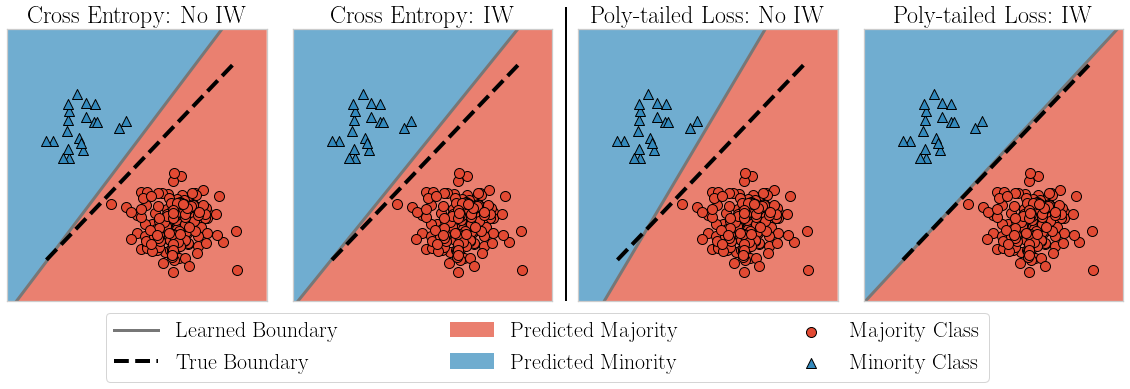

In [8]:
from itertools import product
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

plt.rc('text', usetex=True)
plt.rc('font', family='times')
palette = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
sns.set_palette(palette)


fig, axes = plt.subplots(figsize=(20, 5), ncols=4)

def ymap(xseq, weight, bias):
    print(weight)
    print(bias)
    return (xseq * weight[0] + bias) / (-1 * weight[1])

for i, (loss_type, weight_type) in enumerate(product(["ce", "poly"], ["No IW", "IW"])):
    lr = 1.0
    num_epochs = int(1e5)

    
    torch.random.manual_seed(1)

    class_one_num = 20
    class_two_num = 200
    alpha = 1.0
    num_epochs = int(1e6)
    batch_size = class_one_num + class_two_num
    lr = 0.1
    device = "cuda"

    class_one = truncate_normal(torch.randn(class_one_num, 2), 5) + torch.tensor([[0, 5]])
    class_two = truncate_normal(torch.randn(class_two_num, 2), 5) + torch.tensor([[5, 0]])

    x_seq = torch.cat((class_one, class_two), dim=0)
    y_seq = torch.cat(
        (torch.zeros(class_one.shape[0], dtype=torch.long), torch.ones(class_two.shape[0], dtype=torch.long))
    )
    
    
    model = torch.nn.Linear(2, 2)
    model.load_state_dict(torch.load(f"./weights/model_{weight_type}_{loss_type}_{lr}_{num_epochs}.ckpt"))
    model = model.cpu()
      
    if loss_type == "ce":
        loss_name = "Cross Entropy"
    else:
        loss_name = "Poly-tailed Loss"
    
    ax = axes.flatten()[i]

    xlim = ylim = (-4, 10)
    ax.set(ylim=ylim, xlim=xlim)

    def decision_boundary(model, x0):
        w, b = model.weight.detach().numpy(), model.bias.detach().numpy()
        x1 = ((w[1, 0] - w[0, 0]) * x0 + (b[1] - b[0])) / (w[0, 1] - w[1, 1])
        return x1
    x0 = np.linspace(-4, 10)
    x1 = decision_boundary(model, np.linspace(-4, 10))
    ax.plot(x0, x1, color=palette[3], label="Learned Boundary")
    ax.fill_between(x0, x1 - 100, x1, alpha=0.7, label="Predicted Majority")
    ax.fill_between(x0, x1, x1 + 100, alpha=0.7, label="Predicted Minority")
    
    ax.scatter(class_two[:, 0], class_two[:, 1], c=palette[0], edgecolors="k", marker="o", lw=1, s=100, label="Majority Class")
    ax.scatter(class_one[:, 0], class_one[:, 1], c=palette[1], edgecolors="k", marker="^", lw=1, s=100, label="Minority Class")

    xrng = np.linspace(min(x_seq[:, 0]), max(x_seq[:, 0]), num=50)
    ax.plot(xrng, xrng, color="black", linewidth=4, linestyle="--", label="True Boundary")
    ax.set(xticklabels=[], yticklabels=[])
    ax.set(title=f"{loss_name}: {weight_type}")

    ax.grid(False)
    
import matplotlib.transforms as mtrans

fig.subplots_adjust(wspace=0.1, hspace=0.1)

r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axes.flat[1:3])), mtrans.Bbox).reshape(2)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(len(bboxes)).max(axis=0)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(len(bboxes)).min(axis=0)
ys = np.c_[ymax, ymin].mean(axis=1)

# Draw a horizontal lines at those coordinates
for y in ys:
    line = plt.Line2D([y-0.021,y-0.021],[0.127, 0.94], transform=fig.transFigure, color="black", linewidth=2)
    fig.add_artist(line)

ax = axes.flatten()[1]
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc="lower center", handlelength=2, columnspacing=5, bbox_to_anchor=(0.5, -0.13))

In [9]:
fig.savefig("margin_flat.pdf", bbox_inches="tight")